In [381]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [382]:
from sklearn.linear_model import LogisticRegression

In [242]:
def make_X(mu, sigme, size):
    X = np.random.multivariate_normal(mu, sigme, size)
    return X

In [243]:
def identification_boundary(XX, mu, sigma, pi):
    sigma1 = sigma[0]
    sigma2 = sigma[1]
    mu1 = mu[0]
    mu2 = mu[1]
    pi1 = pi[0]
    pi2 = pi[1]
    
    S = np.linalg.inv(sigma1) - np.linalg.inv(sigma2)
    cT = mu2.T.dot(np.linalg.inv(sigma2)) - mu1.T.dot(np.linalg.inv(sigma1))
    F = mu1.T.dot(np.linalg.inv(sigma1)).dot(mu1) - mu2.T.dot(np.linalg.inv(sigma2)).dot(mu2) + (np.log(np.linalg.det(sigma1)/np.linalg.det(sigma2))) - (2*np.log(pi1/pi2))
    
    return XX.T.dot(S).dot(XX) + (2*cT.reshape(1,2).dot(XX)) + F

In [244]:
def zscore(x):
    xmean = x.mean(axis=0)
    xstd = np.std(x,axis=0)
    return (x - xmean) / xstd

In [279]:
def make_data(mu, sigma, pi, z_score=False, decorrelation=False, distribution=False):
    sigma1 = sigma[0]
    sigma2 = sigma[1]
    mu1 = mu[0]
    mu2 = mu[1]
    pi1 = pi[0]
    pi2 = pi[1]

    if z_score:
        X1 = zscore(make_X(mu1, sigma1, int(size*pi1)))
        X2 = zscore(make_X(mu2, sigma2, int(size*pi2)))
    else:
        X1 = make_X(mu1, sigma1, int(size*pi1))
        Y1 = np.full((1,len(X1)), 1)
        X2 = make_X(mu2, sigma2, int(size*pi2))
        Y2 = np.full((1,len(X1)), 0)
    
    if decorrelation:
        ramda1, S1 = np.linalg.eig(sigma1)
        ramda2, S2 = np.linalg.eig(sigma2)
        X1 = np.dot(S1.T, X1.T).T
        X2 = np.dot(S2.T, X2.T).T
    X = np.vstack((X1,X2))
    Y = np.vstack((Y1,Y2))

    plt.scatter(X1[:,0], X1[:,1])
    plt.scatter(X2[:,0], X2[:,1])

    if not distribution:
        mu1 = X1.mean(axis=0)
        sigma1 = np.cov(X1.T)
        mu2 = X2.mean(axis=0)
        sigma2 = np.cov(X2.T)
    
#    XX1 = np.linspace(X[:,0].min(),X[:,0].max(),100)
#    XX2 = np.linspace(X[:,1].min(),X[:,1].max(),100)
#    XX1_grid, XX2_grid = np.meshgrid(XX1, XX2)
#    XX_grid = np.vstack((XX1_grid.flatten(),XX2_grid.flatten()))

#    T = identification_boundary(XX_grid, (mu1, mu2), (sigma1, sigma2), (pi1, pi2))
#    T = np.diag(T)

#    return XX1, XX2, T.reshape(100,100)
    return X, Y.reshape(-1,1)

In [473]:
def make_glaf(MU1, MU2, SIGMA1, SIGMA2, PI1):
    PI2 = 1 - PI1
    size = 1000
    
    X, Y = make_data((MU1, MU2), (SIGMA1, SIGMA2), (PI1, PI2))
    X = np.hstack((X,np.ones(len(X)).reshape(-1,1)))

    # 正規方程式
    W = np.linalg.inv(X.T.dot(X)).dot(X.T).dot((2*Y - np.ones(len(Y)).reshape(-1,1)))
    
    x1 = np.arange(X[:,0].min(), X[:,0].max(), 1)

    x2 = -(W[0]*x1 + W[2]) / W[1]
    plt.plot(x1,x2)

    # ロジスティック
    clf = LogisticRegression()
    clf.fit(X[:,:2], Y)
    w0 = clf.intercept_[0]
    w1 = clf.coef_[0,0]
    w2 = clf.coef_[0,1]
    x2 = -(w1*x1 + w0) / w2

    plt.plot(x1,x2)

    
    # フィッシャー
    X1 = X[Y[:,0] == 0,:2]
    X2 = X[Y[:,0] == 1,:2]

    mu1 = X1.mean(axis=0)
    sigma1 = np.cov(X1.T)
    mu2 = X2.mean(axis=0)
    sigma2 = np.cov(X2.T)
    m = X[:,:2].mean()

    W_f = np.linalg.inv((pi1*sigma1+pi2*sigma2)/2).dot(mu2-mu1).reshape(-1,1)
    W_f0 = m - W_f.reshape(1,-1).dot((pi1*mu1+pi2*mu2).reshape(-1,1))
    
    a = - (W_f[0] / W_f[1])
    
    m = (mu1 + mu2) / 2
    b = -a * m[0] + m[1]
    
    #x2 = -(W_f[0]*x1 + W_f0) / W_f[1]
    x2 = a*x1 +b

    plt.plot(x1,x2.T)
    plt.ylim(X[:,:2].min(),X[:,:2].max())
    #plt.xlim(-300,300)


    plt.legend(['Normal Equation', 'Logistic Regression','fisher'])
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


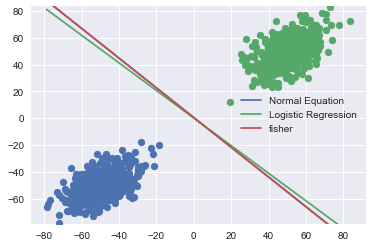

In [474]:
MU1 = np.array([-50, -50])
SIGMA1 = np.array([[100, 50], [50, 100]])
PI1 = 0.5
MU2 = np.array([50, 50])
SIGMA2 = np.array([[100, 50], [50, 100]])

make_glaf(MU1, MU2, SIGMA1, SIGMA2, PI1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


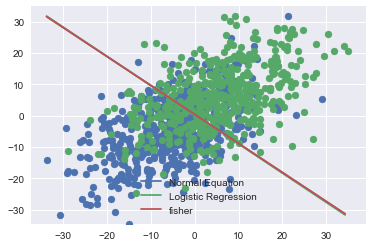

In [475]:
MU1 = np.array([-5, -5])
SIGMA1 = np.array([[100, 50], [50, 100]])
PI1 = 0.5
MU2 = np.array([5, 5])
SIGMA2 = np.array([[100, 50], [50, 100]])

make_glaf(MU1, MU2, SIGMA1, SIGMA2, PI1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


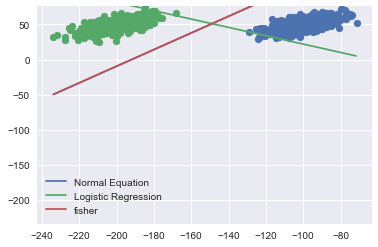

In [476]:
MU1 = np.array([-100, 50])
SIGMA1 = np.array([[100, 50], [50, 60]])
PI1 = 0.5
MU2 = np.array([-200, 50])
SIGMA2 = np.array([[100, 50], [50, 60]])

make_glaf(MU1, MU2, SIGMA1, SIGMA2, PI1)